In [2]:
import os
import json
from argparse import Namespace

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [3]:
from model import load_history_model
from data import Dataset, create_dataloaders

In [39]:
!python train.py --datafrac 0.1 --name test --epochs 2

cpu used for training.
Train size: 1119, Test size: 280
Model Loaded with feature extractor=dnet121, pretrained=False and freeze_extractor=False
Loss: 52.03508758544922, train_acc: 0.16443252563476562, test_acc: 0.14642857015132904
Loss: 51.62656569480896, train_acc: 0.20107237994670868, test_acc: 0.15000000596046448



Epoch 1: 100%|##########| 23/23 [05:56<00:00, 15.50s/it]

Epoch 2: 100%|##########| 23/23 [05:51<00:00, 15.27s/it]


In [41]:
model_name = 'test'
checkpoint_path = os.path.join('checkpoints', model_name)
checkpoint_best = os.path.join(checkpoint_path, 'best.pt')
checkpoint_latest = os.path.join(checkpoint_path, 'latest.pt')
train_args_path = os.path.join(checkpoint_path, 'train_args.txt')

with open(train_args_path, 'r') as f:
    args = Namespace(**json.load(f))
    args.checkpoint = checkpoint_best
    
print(args)

Namespace(lr=0.001, bs=50, epochs=2, datafrac=0.1, freeze_extractor=False, feature_extractor='dnet121', pretrained=False, checkpoint='checkpoints\\test\\best.pt', name='test')


In [42]:
start_epoch, history, model = load_history_model(args)

Model Loaded with feature extractor=dnet121, pretrained=False and freeze_extractor=False
Model weights loaded from checkpoints\test\best.pt into cpu


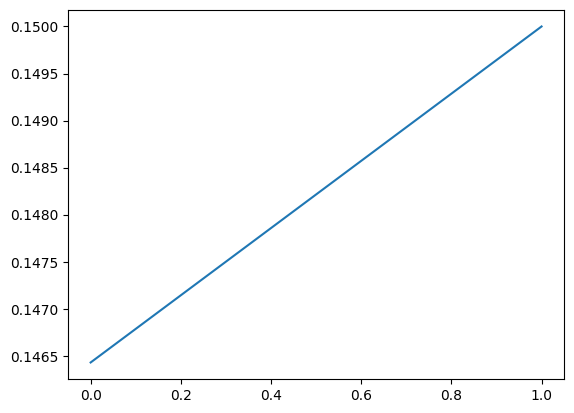

In [43]:
plt.plot(history['test_accuracy'])

In [27]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
test

,image_path,age,age_category,class,gender,ethnicity
0,100_0_0_20170112213500903.jpg.chip.jpg,100,"(90, 100]",9,0,0.0
1,100_1_0_20170110183726390.jpg.chip.jpg,100,"(90, 100]",9,1,0.0
2,11_0_0_20170110220453002.jpg.chip.jpg,11,"(10, 20]",1,0,0.0
3,11_0_0_20170110220657089.jpg.chip.jpg,11,"(10, 20]",1,0,0.0
4,11_0_0_20170110224233654.jpg.chip.jpg,11,"(10, 20]",1,0,0.0
...,...,...,...,...,...,...
2792,9_0_4_20170110215354740.jpg.chip.jpg,9,"(0, 10]",0,0,4.0
2793,9_1_0_20170105000600802.jpg.chip.jpg,9,"(0, 10]",0,1,0.0
2794,9_1_0_20170109203410981.jpg.chip.jpg,9,"(0, 10]",0,1,0.0
2795,9_1_0_20170109204512608.jpg.chip.jpg,9,"(0, 10]",0,1,0.0


In [44]:
# train = train.dropna()
# test = test.dropna()

# Train Set

(array([6173.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        5014.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

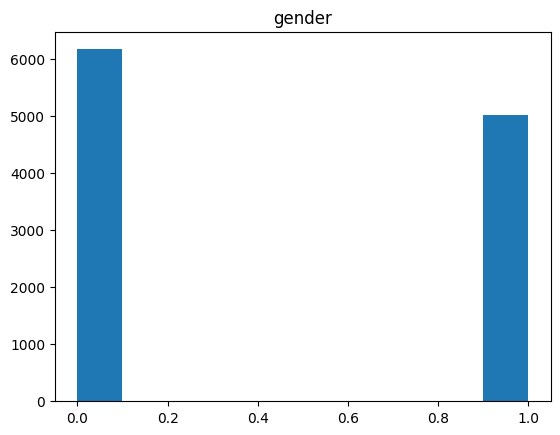

In [45]:
col = "gender"
plt.title(col)
plt.hist(train[col])

There are about 19% more males than females in the dataset

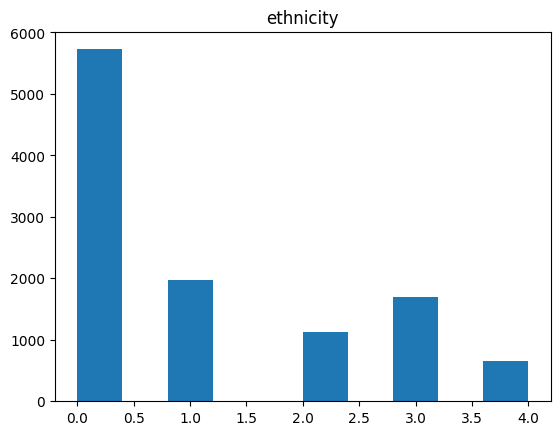

In [46]:
col = "ethnicity"
plt.hist(train[col])
plt.title(col)
plt.show()

# Test set

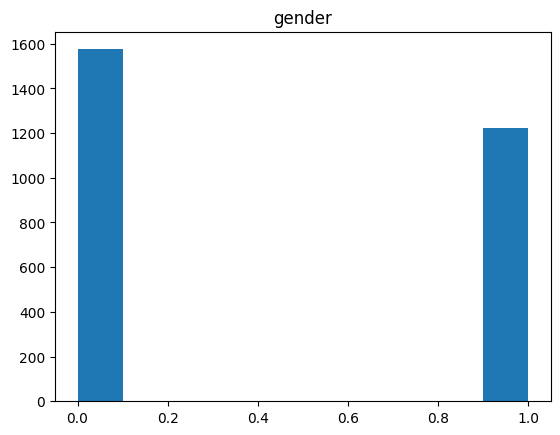

In [47]:
col = "gender"
plt.hist(test[col])
plt.title(col)
plt.show()

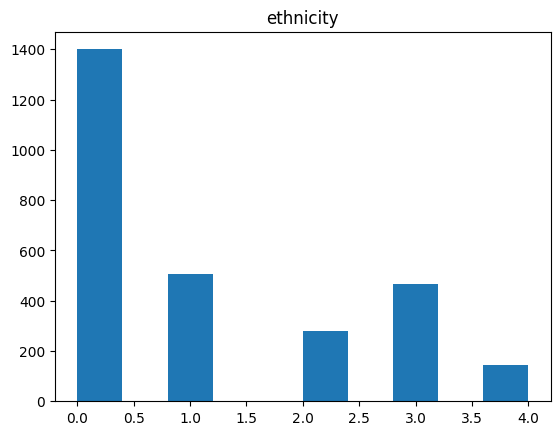

In [48]:
col = "ethnicity"
plt.hist(test[col])
plt.title(col)
plt.show()

In [49]:
if torch.cuda.is_available(): device = 'cuda:0'
else: device = 'cpu'
print(f"{device} used for testing.")

cpu used for testing.


In [50]:
history['test_accuracy'][-1]

0.15000000596046448

In [51]:
test_set = Dataset(test, datafrac=0.1)
test_loader = DataLoader(test_set, batch_size=1)

test_acc = 0
with torch.no_grad():
    model.eval()
    for batch_idx, (X, y, age_cat) in enumerate(test_loader):
        X, y = X.to(device), y.to(device)

        oh = model(X).softmax(dim=1)
        test_acc += (oh.argmax(dim=1) == y.argmax(dim=1)).float().sum() 

    test_acc /= len(test_loader.dataset)
    test_acc = test_acc.to('cpu').item()
    print(f"test_acc: {test_acc}", end=" ")

test_acc: 0.15000000596046448 

In [36]:
def accuracyOn(data, col='gender', colval=0):
    
    data = data[data[col] == colval].dropna()

    test_set = Dataset(data)
    test_loader = DataLoader(test_set, batch_size=1)
    
    test_acc = 0
    with torch.no_grad():
        model.eval()
        for batch_idx, (X, y, age_cat) in enumerate(test_loader):
            X, y = X.to(device), y.to(device)

            oh = model(X).softmax(dim=1)
            test_acc += (oh.argmax(dim=1) == y.argmax(dim=1)).float().sum() 

        test_acc /= len(test_loader.dataset)
        test_acc = test_acc.to('cpu').item()
        print(f"test_acc: {test_acc}", end=" ")
        return test_acc

In [37]:
accuracyOn(test, col='gender', colval=0)

test_acc: 0.48253968358039856 

0.48253968358039856

In [38]:
accuracyOn(test, col='gender', colval=1)

test_acc: 0.4492635130882263 

0.4492635130882263